In [1]:
# default_exp geometry.meshed_geometry

# Create meshed geometry

> API details.

In [2]:
#hide
from nbdev.showdoc import *
import matplotlib
import matplotlib.pyplot as plt

In [3]:
#export
import os

In [4]:
#hide
import sys

sys.path.append(os.path.join(os.getcwd(), '..'))

In [5]:
#export
import numpy as np
import gmsh

from accelerate_simulations.geometry import AbstractGeometry

In [6]:
#hide
import meshio

In [7]:
#hide
box_size = (100, 100)
circle_radius = 5
n_circles = 10

In [8]:
#hide
abstract_geometry = AbstractGeometry(n_circles, circle_radius, box_size, 42)
abstract_geometry.n_circles

10

In [22]:
#export
def make_msh(output_path, abstract_geometry, cl_coarse, cl_fine, verbose, path_to_tethex):
    circle_centers, circle_radius, box_corner_coords = abstract_geometry.get_geom_info()
    
    # Before using any functions in the Python API, Gmsh must be initialized:
    gmsh.initialize()

    gmsh.option.setNumber("Mesh.MshFileVersion", 2.2) # makes sure that the output of the file is in gmsh 2 format
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2) # it makes sure there are only quad elements
    gmsh.option.setNumber("Mesh.RecombineAll", 2) # recombine all surfaces

    point1 = gmsh.model.geo.addPoint(box_corner_coords[0][0], box_corner_coords[0][1], 0, cl_coarse)
    point2 = gmsh.model.geo.addPoint(box_corner_coords[1][0], box_corner_coords[1][1], 0, cl_coarse)
    point3 = gmsh.model.geo.addPoint(box_corner_coords[2][0], box_corner_coords[2][1], 0, cl_coarse)
    point4 = gmsh.model.geo.addPoint(box_corner_coords[3][0], box_corner_coords[3][1], 0, cl_coarse)
    
    line1 = gmsh.model.geo.addLine(point1, point2)
    line2 = gmsh.model.geo.addLine(point2, point3)
    line3 = gmsh.model.geo.addLine(point3, point4)
    line4 = gmsh.model.geo.addLine(point4, point1)

    circle_loops = []
    circle_surfaces = []
    for idx, circle_center in enumerate(circle_centers):
        x, y = circle_center

        points = gmsh.model.geo.addPoint(x+circle_radius, y, 0, cl_fine)
        pointc = gmsh.model.geo.addPoint(x, y, 0, cl_fine)
        pointe = gmsh.model.geo.addPoint(x-circle_radius, y, 0, cl_fine)
        
        hcircle1 = gmsh.model.geo.addCircleArc(points, pointc, pointe)
        hcircle2 = gmsh.model.geo.addCircleArc(pointe, pointc, points)
        
        circle_loop = gmsh.model.geo.addCurveLoop([hcircle1, hcircle2])
        surface = gmsh.model.geo.addPlaneSurface([circle_loop])
        
        circle_loops.append(circle_loop)
        circle_surfaces.append(surface)

    line_loop1 = gmsh.model.geo.addCurveLoop([line1, line2, line3, line4])
    surface1 = gmsh.model.geo.addPlaneSurface([line_loop1] + circle_loops)

    # make sure that tag argument remains the same, these are also set in the FEM model
    gmsh.model.addPhysicalGroup(dim=2, tags=[surface1], tag=2)
    gmsh.model.addPhysicalGroup(dim=2, tags=circle_surfaces, tag=1)

    gmsh.model.addPhysicalGroup(dim=1, tags=[line1], tag=4)
    gmsh.model.addPhysicalGroup(dim=1, tags=[line2], tag=5)
    gmsh.model.addPhysicalGroup(dim=1, tags=[line3], tag=6)
    gmsh.model.addPhysicalGroup(dim=1, tags=[line4], tag=3)

    # Before they can be meshed (and, more generally, before they can be used by API
    # functions outside of the built-in CAD kernel functions), the CAD entities must
    # be synchronized with the Gmsh model, which will create the relevant Gmsh data
    # structures.

    gmsh.model.geo.synchronize()

    # We can then generate a 2D mesh...
    gmsh.model.mesh.generate(dim=2)

    # refine once
    gmsh.model.mesh.refine()

    # ... and save it to disk
    gmsh.write(output_path)

    # This should be called when you are done using the Gmsh Python API:
    gmsh.finalize()

    # os.system(f'{path_to_tethex} {output_path} {output_path.replace(".msh", "_hex.msh")} {int(verbose)}')

In [23]:
make_msh('../../test.msh', abstract_geometry, cl_coarse=5, cl_fine=2, verbose=True, path_to_tethex='~/dev/tethex/build/tethex')

In [12]:
mesh = meshio.read('../../test.msh')

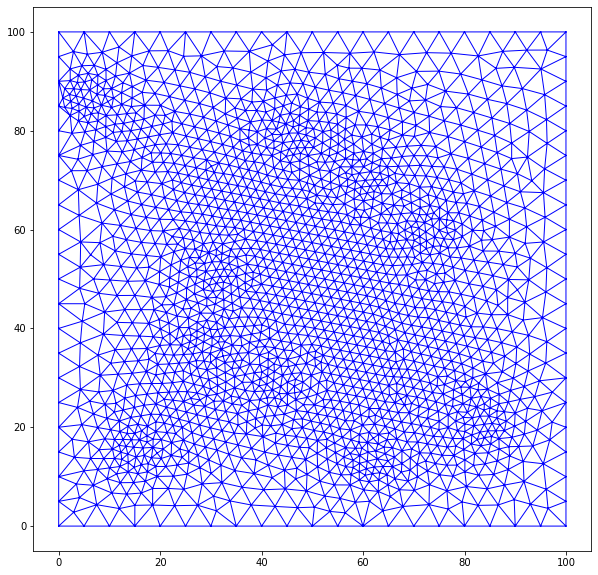

In [56]:
from scipy.spatial import Delaunay

mesh_delaunay = Delaunay(mesh.points[:, :2])
mesh_delaunay.simplices = np.array(mesh.cells_dict["triangle"])

plt.figure(figsize=(10, 10))
triangulation = matplotlib.tri.Triangulation(mesh_delaunay.points[:, 0], mesh_delaunay.points[:, 1], mesh_delaunay.simplices)
plt.triplot(triangulation, color='b', linewidth=1, alpha=1.0);
